# CAB420, DCNNs, Example 3: What Does the Network Learn?
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This example is all about exploring what is being learned by a DCNN. Please note I'm not worried about performance in here. The networks that we're using a very simple, because simple networks are easier to visualise. **Performance of models is not the focus here.** We're going to train a few networks, and after training there will be a confusion matrix, but this is really just here as a sanity check to make sure that something actually trained.

This example really is very visual, it's all about looking at the pretty pictures to try and get a sense of what is actually being learnt. As such, there is no TL;DR section here (sorry).

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import datetime
import numpy

import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

E0000 00:00:1738039646.944016  503875 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738039646.947772  503875 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The Data

We'll stick with FashionMNIST. Same setup as before.

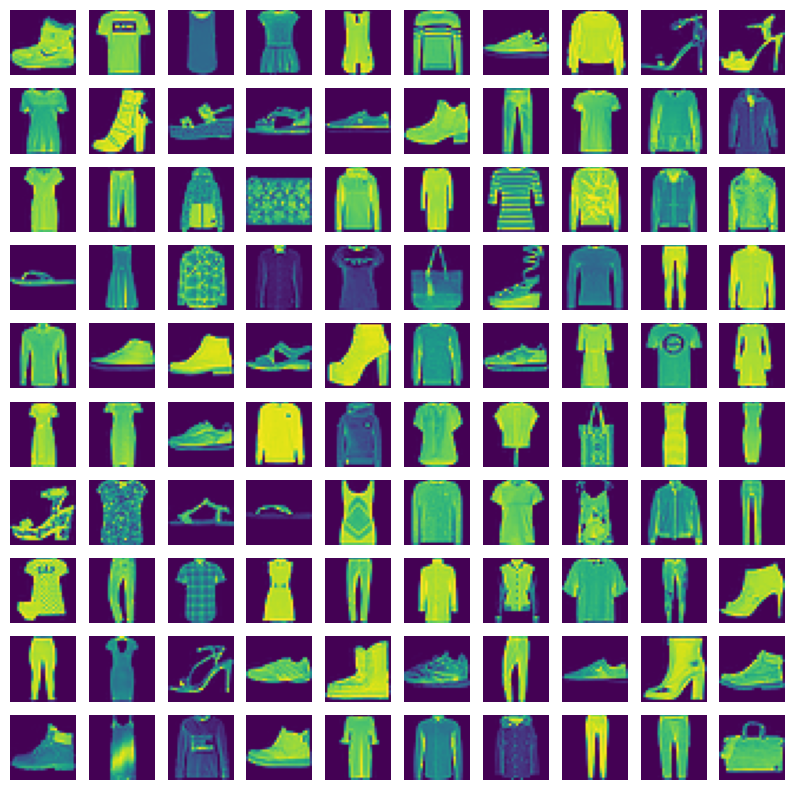

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:])
    ax.axis('off')
    
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

## A Very Simple Model

This is as simple as it gets. We have:
* An input layer, each pixel in the image is a feature, so we have an input shape of `(784, )`
* An output layer, with 10 neurons, one for each type of clothing

At this point we're not using a convolutional neural net, we're just learning a single dense layer, and if we're being picky about this, this is not actually a deep learning model. We have no intermediate layers, we're just going directly from an input to the output.

In [3]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(784,), name='x')
outputs = layers.Dense(10, activation='softmax', name='y')(inputs)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

I0000 00:00:1738039650.426365  503875 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1281 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:0b.0, compute capability: 8.6


Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ x (InputLayer)                  │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y (Dense)                       │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Before we go further, let's consider what is learnt here. We have a very small number of parameters for a neural network. These arise from learning the mapping from the input (a length $784$ vector) to the output, which is a vector that captures which of the $10$ classes a sample belongs to. We compute this mapping via

$y = Wx + b$

where $y$ is our output, $x$ is our input, $W$ is a weight matrix of size $[784, 10]$ (i.e. $7,840$ parameters), and $b$ is a bias vector of size $10$ (i.e. $10$ parameters, giving us all up the $7,850$ parameters you see above). That formula should look very familar. We've seen it with linear regression and with SVMs, and while the form repeats again here (and in a lot of other places in machine learning) in each of these situations we solve for $W$ and $b$ in slightly different ways.

One way in which the above differs from regression and SVMs is that our output is not a single value, rather it is 10 values. We could decompose this whole operation into $10$ independant operations as follows:

$y[0] = W[:,0]x + b[0]$

$y[1] = W[:,1]x + b[1]$

...

$y[9] = W[:,9]x + b[9]$

such that each neuron in y (which indicates if a given class is observed in the input) is the result of the corresponding column in $W$, multiplied by the input, plus a bias term. While we can think of the model in this way, I feel this is somewhat inaccurate as we don't learn each column of $W$, or each value of $b$, separately. The entire thing is learnt as one - so if anything we could view this as learning $10$ binary classifiers jointly.

With that out the way, we'll train and evaluate our model.

In [4]:
def eval_model(model, x_test, y_test):
    pred = model.predict(x_test, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
        
def train_and_eval(model, x_train, y_train, x_test, y_test):
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
    history = model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
    
    eval_model(model, x_test, y_test)
    
    return model

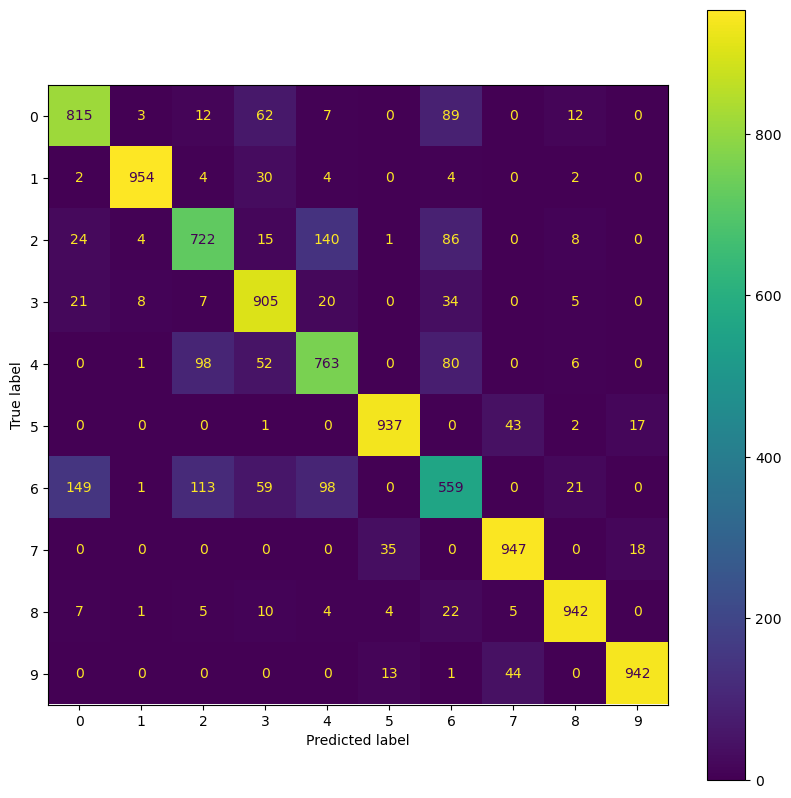

In [5]:
model = train_and_eval(model, x_train, y_train, x_test, y_test)

The end result of this is a model that actually does quite Ok. To confirm how this all works, we can pull out the learned weights and baises as follows.

In [6]:
w = model.get_layer('y').get_weights()[0]
print(w.shape)
b = model.get_layer('y').get_weights()[1]
print(b.shape)

(784, 10)
(10,)


These are the shapes that we expected.

We can then use these to make a prediction. I can do this either for all classes at once, or for one class by using the appropriate bits of $W$ and $b$.

In [7]:
prediction = numpy.matmul(x_train[0,:], w) + b
print(prediction)
prediction_class_0 = numpy.matmul(x_train[0,:], w[:,0]) + b[0]
print(prediction_class_0)

[-11.771577  -20.336937  -10.636065  -14.762085  -12.946816    4.9850845
  -5.6918483   5.252544   -1.1772566  12.836748 ]
-11.771574


One thing you will notice here is that our values are not in the range $[0..1]$. What we have here are the *logits*, these are the outputs from the network before passing them though a softmax function. If we want, we can apply a softmax as follows

In [8]:
print(keras.activations.softmax(prediction))

tf.Tensor(
[2.0528150e-11 3.9125731e-15 6.3899434e-11 1.0317848e-12 6.3379649e-12
 3.8875488e-04 8.9689713e-09 5.0796289e-04 8.1922855e-07 9.9910247e-01], shape=(10,), dtype=float32)


and then we can get a result that perfectly matches what we get from the predict function of our model.

In [9]:
print(model.predict(x_train[0:1,:], verbose=False))

[[2.0528386e-11 3.9126032e-15 6.3899920e-11 1.0317927e-12 6.3380369e-12
  3.8875785e-04 8.9690566e-09 5.0796679e-04 8.1923253e-07 9.9910247e-01]]


## But what about Convolutions?

Let's face it, you weren't here to look at what a dense layer does, so we'll onto convolutions now. 

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

Again, we'll keep our network insanely simple. We'll use:
* An input layer, this time we'll keep our data as an image, as we're using a Conv2D layer
* A single Conv2D layer, with 8 3x3 filters
* A dense layer, with 10 outputs, i.e. our final result

The network also has an activation (a relu) and a flatten in there. I could have the relu "baked in" to the Conv2D layer via the `activation` arguement if I wanted. In this case, I don't want to do this as I want to visualise what's happening in this layer, and I'd like to see the output of the layer *before* the relu. If I had the relu in the layer itself (i.e. if I had `activation='relu'`) then this would not be possible. The flatten is needed to get the data in a form ready to go into the output layer.

In [11]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(28, 28, 1,), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same', name='Conv2D_1')(inputs)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        62,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,810 (245.35 KB)

 Trainable params: 62,810 (245.35 KB)

 Non-trainable params: 0 (0.00 B)

We'll quickly recap what's happening in the convolutional layer in terms of parameters and operations. `Conv2D_1` has $80$ parameters, as we have $8$ filters, this is simply $10$ parameters per filter. Each filter has some weights, the size of which is $w \times h \times c_{in}$, where $w$ and $h$ are the width and height of the filter, and $c_{in}$ is the number of channels in the input. For our network, $w=3$, $h=4$, $c_{in}=1$. Each filter also has $1$ bias term.

Each filter is applied to the input individually,

$y_i = w_i \ast x + b_i$

generating a *feature map*, $y_i$. If we have $8$ filters, we get 8 feature maps. As such, we see the output shape of our convolution is `(None, 28, 28, 8)` (remember that the `None` is a placeholder for the number of samples in a batch). Each of the filters will (hopefully) learn a respresentation that responds to something different. This means that after the layer, our network will have 8 feature maps, that will indicate the presence (or absense) of different (hopefully interesting) things.

I0000 00:00:1738039678.676862  503914 cuda_dnn.cc:529] Loaded cuDNN version 90300


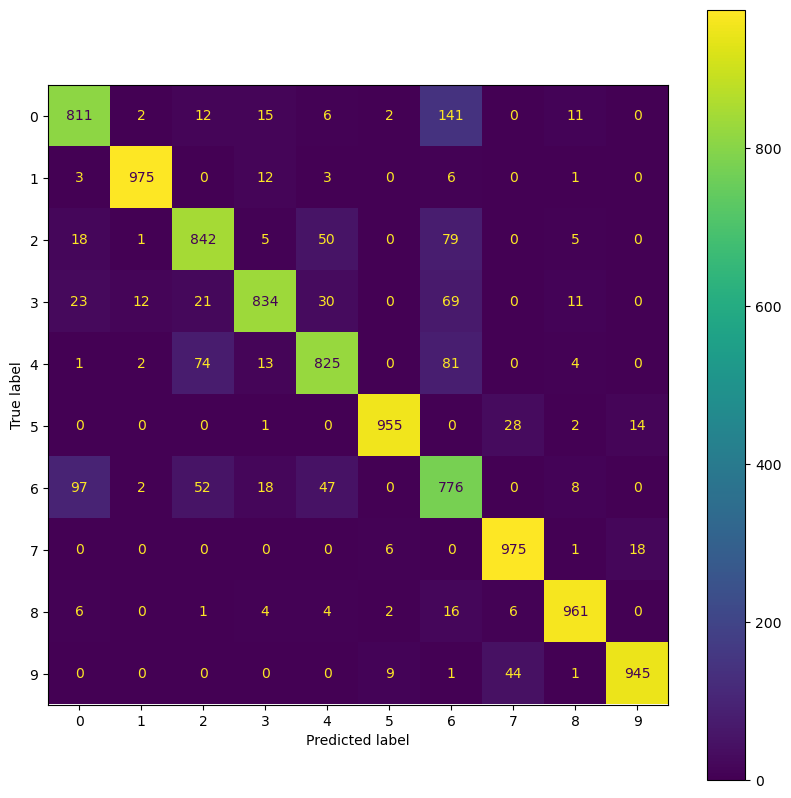

In [12]:
model = train_and_eval(model, x_train, y_train, x_test, y_test)

Our model is trained, it works ok, and that's all we'll say about that. Instead, let's look at what the `Conv2D_1` layer has learned. Below, I'm going to visualise the filters, and the responses to each filter for 10 input images. The figure shows
* The actual $3 \times 3$ filters in the top row;
* The input images down the left; and
* The response that we get when each filter is applied to each image in the rest of the table.

Don't get hung up on the colour scale of the images below, as each image is having it's colour scaled separately by the display function.

I0000 00:00:1738039710.963588  503915 service.cc:148] XLA service 0x7f21a82abb10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738039710.963628  503915 service.cc:156]   StreamExecutor device (0): NVIDIA A16-4Q, Compute Capability 8.6
I0000 00:00:1738039711.114326  503915 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


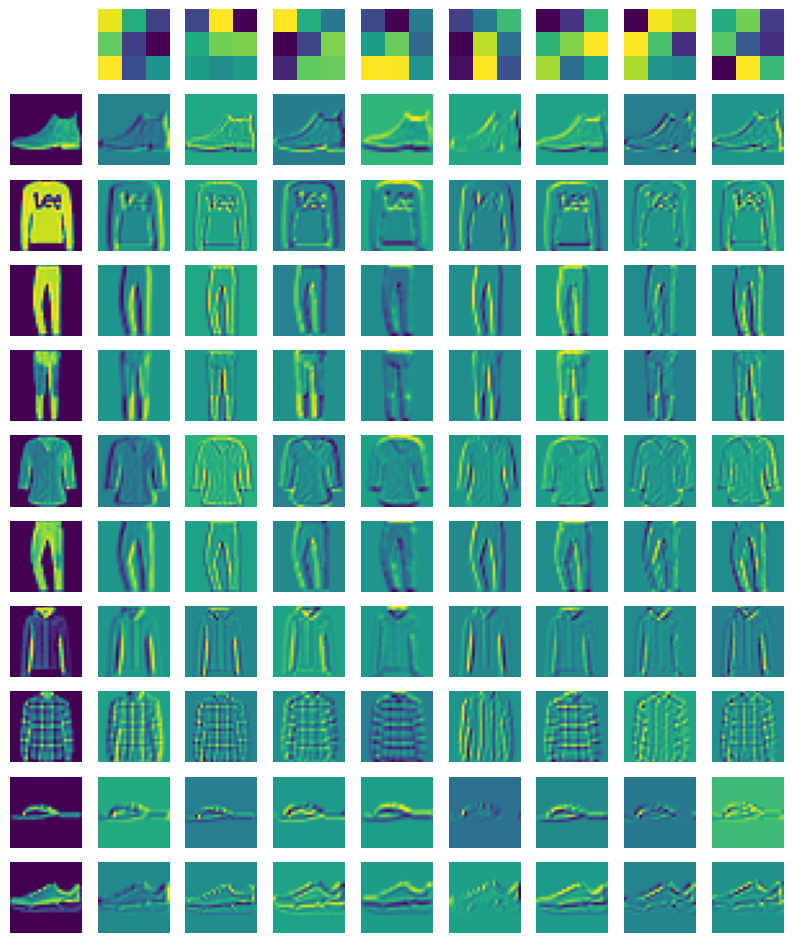

In [13]:
conv1_output = model.get_layer('Conv2D_1').output 
conv1_model = keras.Model(inputs = model.input, outputs = conv1_output)
conv1_prediction = conv1_model.predict(x_test[0:10,:,:,:], verbose=False)
conv_weights = model.get_layer("Conv2D_1").get_weights()[0]
    
n_img = 10
n_filt = 8
plt.figure(figsize=(10, 12))
for j in range(n_filt):
    ax = plt.subplot(n_img + 1, n_filt + 1, j + 2)
    ax.axis('off')
    ax.imshow(conv_weights[:,:,0,j])
    
for i in range(n_img):
    ax = plt.subplot(n_img + 1, n_filt + 1, (i+1)*(n_filt + 1) + 1)
    ax.axis('off')
    ax.imshow(x_test[i,:,:,0])
    
    for j in range(n_filt):
        ax = plt.subplot(n_img + 1, (n_filt + 1), (i+1)*(n_filt + 1) + 1 + j + 1)
        ax.axis('off')
        ax.imshow(conv1_prediction[i][:, :, j])

To understand the above, remember what the convolution operation is actually doing. It's taking the filter weights (top row), and a window of the same size in the image (i.e. $3 \times 3$). It's then doing an element-wise multiplication between the two, and summing it all up, for a single $3\times 3$ patch this would look like

$y = \sum_{i=1}^3{ \sum_{j=1}^3 w_{i,j}x_{i,j}} + b$.

As such, when we have a situation where the large weights in the filter overlap with large values in the image, we can get strongly positive responses, which will show up as brighter regions in the response map. We for example that a number of our filters are good at locating edges at different orientations. All of our filter responses also clearly resemble the input image in some way (which is what we'd expect when applying a simple filter).

In an early (nearer the input) convolutional layer like this, particularly with a small filter, we won't learn very complex features. We'll typically see exactly what we see here: details such as at edges, at different orientations, being highlighted. Typically, we'll see each filter results in a number of high responses, i.e. we don't have each filter just finding one location, rather a number of locations will achieve a similar maximum response.

### Bigger Convolution Filters

But what if we use bigger convolution kernels?

In [14]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(28, 28, 1,), name='img')
x = layers.Conv2D(filters=8, kernel_size=(7,7), activation=None, padding='same', name='Conv2D_1')(inputs)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 28, 28, 8)      │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        62,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,130 (246.60 KB)

 Trainable params: 63,130 (246.60 KB)

 Non-trainable params: 0 (0.00 B)

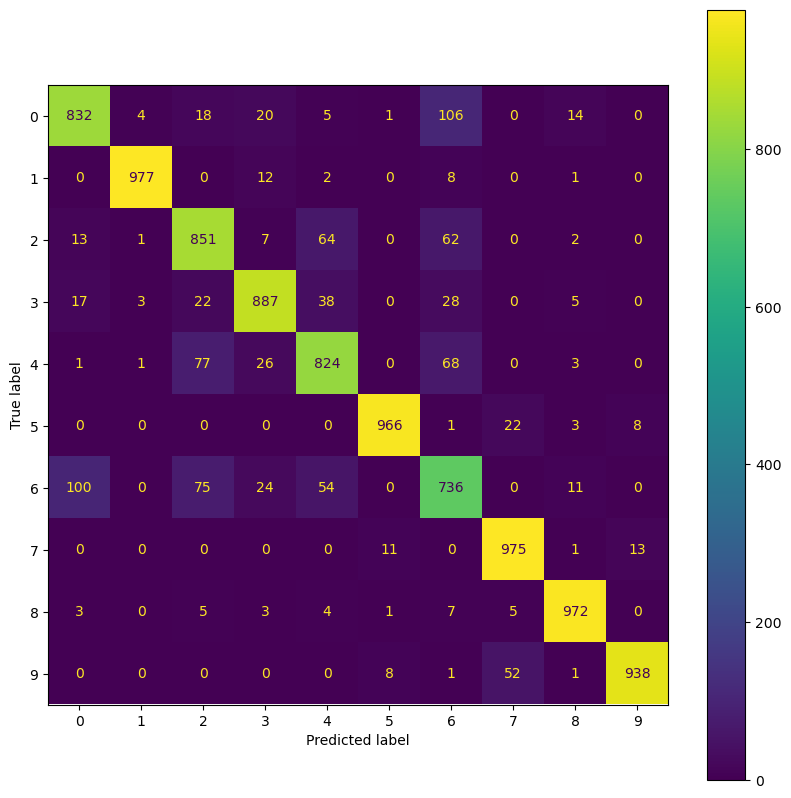

In [15]:
model = train_and_eval(model, x_train, y_train, x_test, y_test)

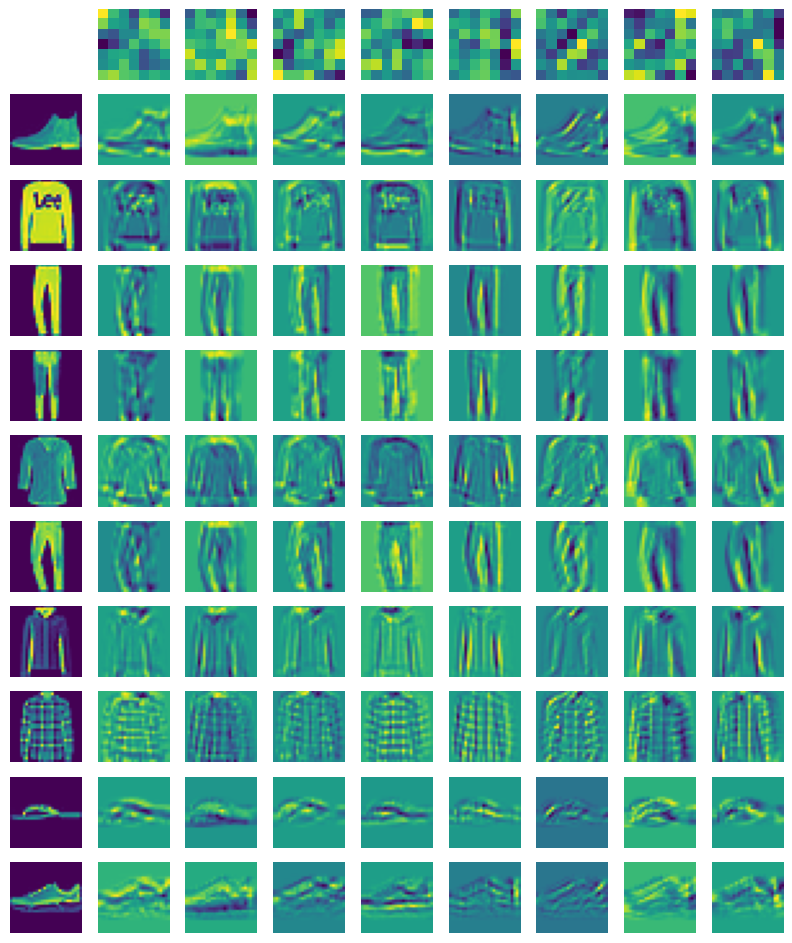

In [16]:
conv1_output = model.get_layer('Conv2D_1').output 
conv1_model = keras.Model(inputs = model.input, outputs = conv1_output)
conv1_prediction = conv1_model.predict(x_test[0:10,:,:,:], verbose=False)
conv_weights = model.get_layer("Conv2D_1").get_weights()[0]
    
n_img = 10
n_filt = 8
plt.figure(figsize=(10, 12))
for j in range(n_filt):
    ax = plt.subplot(n_img + 1, n_filt + 1, j + 2)
    ax.axis('off')
    ax.imshow(conv_weights[:,:,0,j])
    
for i in range(n_img):
    ax = plt.subplot(n_img + 1, n_filt + 1, (i+1)*(n_filt + 1) + 1)
    ax.axis('off')
    ax.imshow(x_test[i,:,:,0])
    
    for j in range(n_filt):
        ax = plt.subplot(n_img + 1, (n_filt + 1), (i+1)*(n_filt + 1) + 1 + j + 1)
        ax.axis('off')
        ax.imshow(conv1_prediction[i][:, :, j])

Here, we've used a $7 \times 7$ kernel. We're still only using 8 filters to avoid this being too hard to visualise, but we see very different looking results to what we had above. In particular:
* Out filters are now much more complex, and much more varied;
* Our outputs are no longer as clearly recogniseable as being derived from the source image (though it's mostly still pretty obvious)
* Our outputs often have only a few locations (or even just 1) with a high activation value

Having larger filters allows our filters to be more selective (leading to fewer locations being active), essentially allowing our filters to find very specific details that aren't visible in a smaller window. The problem however is that the number of possible $7 \times 7$ patterns is much, much larger than the number of possible $3 \times 3$ patterns. This means that to find all the interesting things that help us tell shoes from pants, we need a lot more filters.

## Stacking Convolutions

We now come to stacking convolutions. This is where it might get a bit confusing. I've got the following:
* An input image
* A 2D Convolution layer, with 3 filters this time, of size $3 \times 3$
* An activation and MaxPooling layer
* Another 2D convolution layer, with 8 filters, of size $3 \times 3$
* An activation, flatten, and output layer

The reason for the three filters in the first Conv2D layer is down to visualisation (this is very much **not** about performance). If we learn 3 filters, we have three output channels, and the filters in the second convolution layer will be $3 \times 3 \times 3$ is size (remember, filters are of size $w \times h \times c_{in}$). This means we can visualise the complete output of the first convolution layer, and the filters learnt by the second convolution layer, as colour images.

In [17]:
# create an input, we need to specify the shape of the input, in this case it's a vectorised images with a 784 in length
inputs = keras.Input(shape=(28, 28, 1,), name='img')
x = layers.Conv2D(filters=3, kernel_size=(3,3), activation=None, padding='same', name='Conv2D_1')(inputs)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation=None, padding='same', name='Conv2D_2')(x)
x = layers.Activation('relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# create the model, the model is a collection of inputs and outputs, in our case there is one of each
model = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_model')
# print a summary of the model
model.summary()

Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 28, 28, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 14, 14, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        15,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,944 (62.28 KB)

 Trainable params: 15,944 (62.28 KB)

 Non-trainable params: 0 (0.00 B)

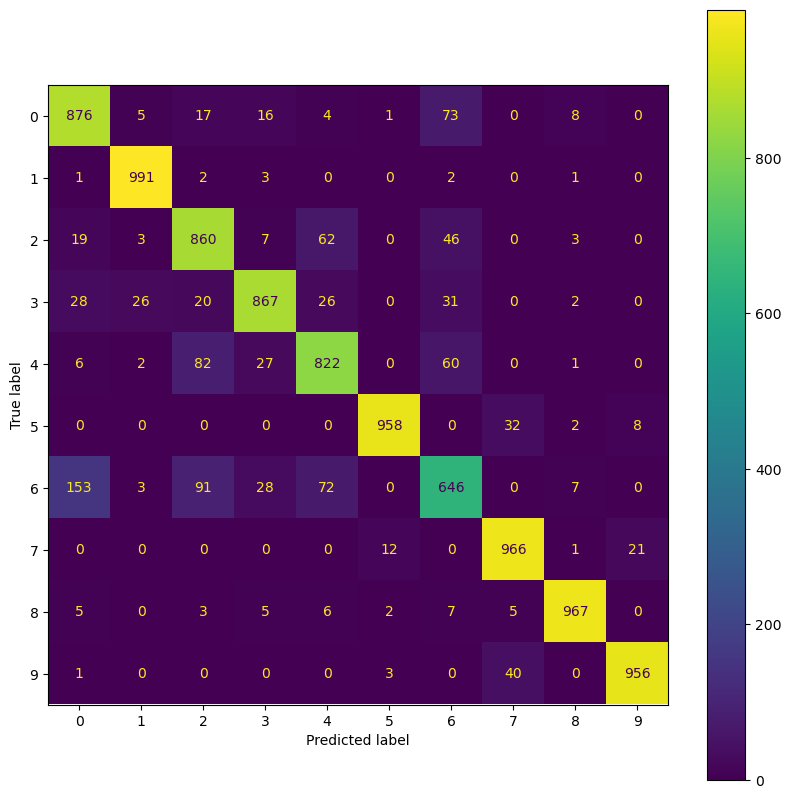

In [18]:
model = train_and_eval(model, x_train, y_train, x_test, y_test)

Again, our model kind-of works, but that's not why we're here. Let's start by looking at the output of the first convolution layer.

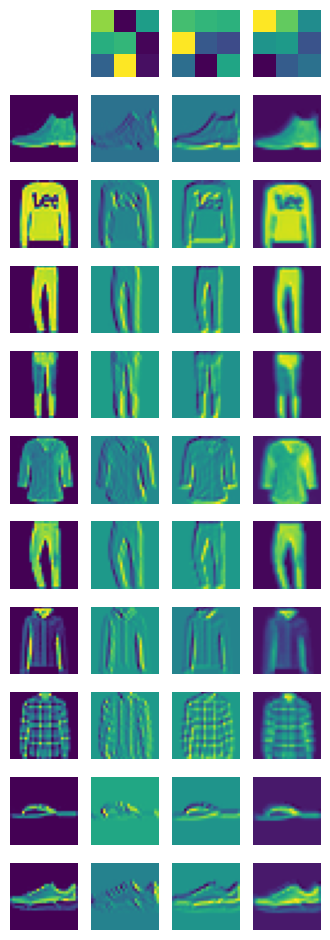

In [19]:
conv1_output = model.get_layer('Conv2D_1').output 
conv1_model = keras.Model(inputs = model.input, outputs = conv1_output)
conv1_prediction = conv1_model.predict(x_test[0:10,:,:,:], verbose=False)
conv_weights = model.get_layer("Conv2D_1").get_weights()[0]
    
n_img = 10
n_filt = 3
plt.figure(figsize=(4, 12))
for j in range(n_filt):
    ax = plt.subplot(n_img + 1, n_filt + 1, j + 2)
    ax.axis('off')
    ax.imshow(conv_weights[:,:,0,j])
    
for i in range(n_img):
    ax = plt.subplot(n_img + 1, n_filt + 1, (i+1)*(n_filt + 1) + 1)
    ax.axis('off')
    ax.imshow(x_test[i,:,:,0])
    
    for j in range(n_filt):
        ax = plt.subplot(n_img + 1, (n_filt + 1), (i+1)*(n_filt + 1) + 1 + j + 1)
        ax.axis('off')
        ax.imshow(conv1_prediction[i][:, :, j])

Really, this just looks like a reduced version of what we had before with 8 $3 \times 3$ filters. Again we're picking up things like edges, just fewer of them as we have fewer filters.

Now we'll move onto the second convolution. Below, we'll show:
* The convolution filters on the top row, now as colour images as each filter is a $3 \times 3 \times 3$ set of weights
* The input image on the left
* The output of the first convolution layer, which is the input to the second, in the column second from the left
* The filter responses, when applying the filters to the output of the first convolution layer

Our responses are all single channel results, and as we have 8 filters, our overall output is 8 channels.

Up above I cautioned against reading too much into intensities and the like with respect to the filters and the responses, the same applies here.

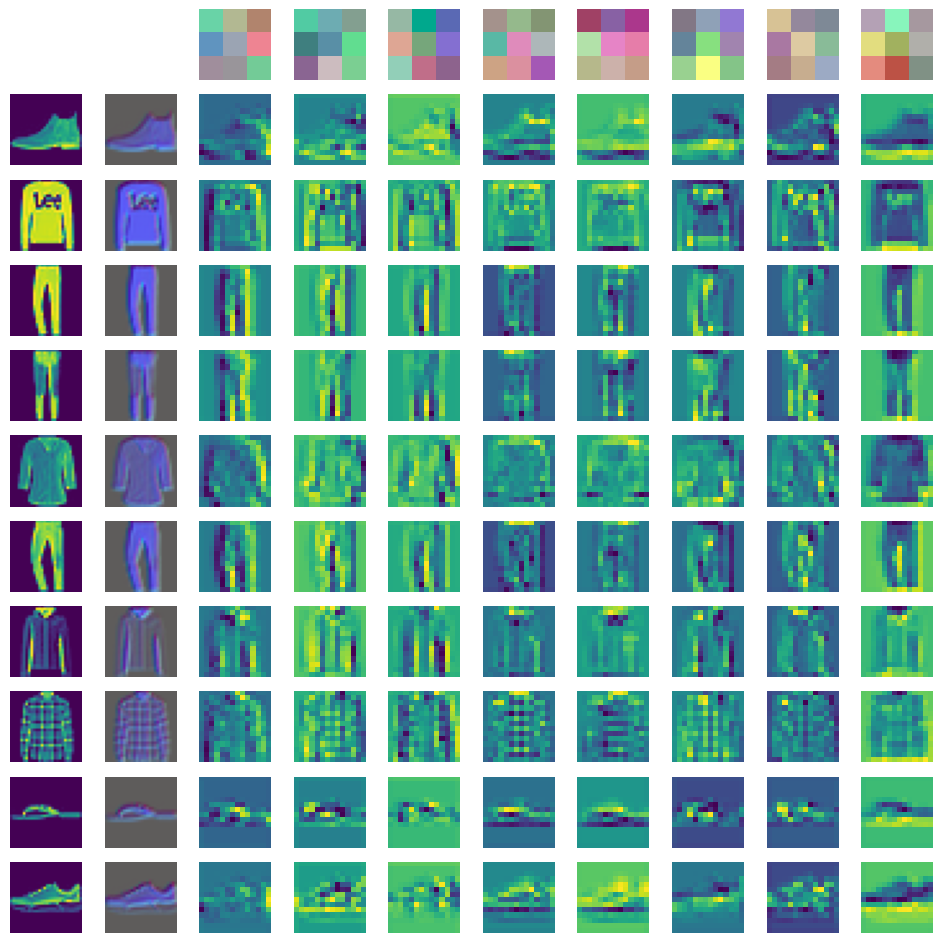

In [20]:
def scale_weights(w):
    return (w - w.min()) / (w.max() - w.min())

conv2_output = model.get_layer('Conv2D_2').output 
conv2_model = keras.Model(inputs = model.input, outputs = conv2_output)
conv2_prediction = conv2_model.predict(x_test[0:10,:,:,:], verbose=False)
conv_weights = scale_weights(model.get_layer("Conv2D_2").get_weights()[0])
conv1_prediction_scaled = scale_weights(conv1_prediction)
    
n_img = 10
n_filt = 8
plt.figure(figsize=(12, 12))
for j in range(n_filt):
    ax = plt.subplot(n_img + 1, n_filt + 2, j + 3)
    ax.axis('off')
    ax.imshow(conv_weights[:,:,:,j])
    
for i in range(n_img):
    ax = plt.subplot(n_img + 1, n_filt + 2, (i+1)*(n_filt + 2) + 1)
    ax.axis('off')
    ax.imshow(x_test[i,:,:,0])
    
    ax = plt.subplot(n_img + 1, n_filt + 2, (i+1)*(n_filt + 2) + 2)
    ax.axis('off')
    ax.imshow(conv1_prediction_scaled[i][:,:,:])
    
    for j in range(n_filt):
        ax = plt.subplot(n_img + 1, (n_filt + 2), (i+1)*(n_filt + 2) + 2 + j + 1)
        ax.axis('off')
        ax.imshow(conv2_prediction[i][:, :, j])

In interpreting the above, let's start with the column second from the left, the output from the first convolutional layer. This looks a bit like one of those 3D images where the 3D effect becomes evident once you pop on the blue and red glasses. Each channel is highlighting a different primitive feature of the input, such an edge of a particular orientation.

Now, consider the filters (top row). We have some multi-coloured tiles here, which shows us that our filters are looking for patterns *across* the three channels. A white (or white-ish) tile square will have a strong response to a location that has a high value across all three channels. A red-ish square will respond strongly to a location where there is a high value in the red channel. A yellow square would record a strong response to a location where there is a high value in both green and blue channels. The fact that our filters feature all the colours of the rainbow indicates that they are looking for locations that have patterns that occur across the channels, this might mean they are looking for particularly combinations of edges, allowing them to describe more complex shapes.

Finally, we'll discuss the actual filter responses. These have more in common with our $7 \times 7$ outputs than our earlier $3 \times 3$ results. We're seeing filter response maps that bear much less of a resemblence to the input image, and that are often a lot more selective (i.e. fewer locations recording a high response). Note too that this representation is smaller spatially, it's only $14 \times 14$, we've got a maxpooling layer in there. 

Like with our $7 \times 7$ convolutions, the number of possible useful patterns to detect is way higher in this layer than it was in the first layer. Our first convolutional layer looks for patterns in the input; here we look for patterns in those patterns; the next layer (if we had one) would look for patterns in the patterns of patterns; and the whole thing would contine until our network disapeared up it's own backside (or training collapsed, or we ran out of memory). This is why we typically see the number of convolution filters increases as we go deeper in the network, there are simply more things to look for. Importantly, we don't need large filters to capture this complexity. The patterns we're able to pick out above with our second convolution layer are just as odd as we had when using $7 \times 7$ filters, and even though we're using small filters the stacking effect means that we're still able to have these filters consider large areas. This is down the *receptive field* of the network. 